In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

log_dir = Path("./data")
files = sorted(log_dir.glob("log_*.txt"))

files

[PosixPath('data/log_01.txt'),
 PosixPath('data/log_02.txt'),
 PosixPath('data/log_03.txt'),
 PosixPath('data/log_04.txt'),
 PosixPath('data/log_05.txt'),
 PosixPath('data/log_06.txt'),
 PosixPath('data/log_07.txt')]

In [3]:
with open(files[0], "r", encoding="utf-8", errors="replace") as f:
    for i in range(5):
        print(f.readline())

2025-05-20T04:46:36.000Z [2025-05-20T13:46:36.270973500] IP=110.35.168.207 METHOD=GET URI=/api/notices/784 STATUS=200 TIME=10ms UA=Mozilla/5.0 (iPhone; CPU iPhone OS 16_6 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/15E148 Safari/604.1 KAKAOTALK/25.3.5 (INAPP)

2025-05-20T04:47:14.000Z [2025-05-20T13:47:14.133040345] IP=59.187.210.89 METHOD=GET URI=/api/booth/undefined/35 STATUS=400 TIME=3ms UA=Mozilla/5.0 (iPhone; CPU iPhone OS 18_4_1 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) CriOS/136.0.7103.91 Mobile/15E148 Safari/604.1

2025-05-20T04:47:19.000Z [2025-05-20T13:47:19.891645433] IP=106.101.195.135 METHOD=GET URI=/api/notices STATUS=200 TIME=1ms UA=Mozilla/5.0 (iPhone; CPU iPhone OS 18_4_1 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/18.4 Mobile/15E148 Safari/605.1 NAVER(inapp; search; 2000; 12.12.70; 15PRO)

2025-05-20T04:47:28.000Z [2025-05-20T13:47:28.842255827] IP=106.101.195.135 METHOD=GET URI=/api/booth/20 STATUS=200 TIME=7ms UA=

In [4]:
pattern = re.compile(
    r'^(?P<ts>\S+)\s+\[.*?\]\s+IP=(?P<ip>\S+)\s+METHOD=(?P<method>\S+)\s+URI=(?P<uri>\S+)\s+STATUS=(?P<status>\d+)\s+TIME=(?P<time>\d+)ms\s+UA=(?P<ua>.*)$'
)

rows = []

for fp in files:
    with open(fp, "r", encoding="utf-8", errors="replace") as f:
        for line in f:
            line = line.strip()
            m = pattern.match(line)
            if m:
                rows.append(m.groupdict())

df = pd.DataFrame(rows)

df.head()

,ts,ip,method,uri,status,time,ua
0,2025-05-20T04:46:36.000Z,110.35.168.207,GET,/api/notices/784,200,10,Mozilla/5.0 (iPhone; CPU iPhone OS 16_6 like M...
1,2025-05-20T04:47:14.000Z,59.187.210.89,GET,/api/booth/undefined/35,400,3,Mozilla/5.0 (iPhone; CPU iPhone OS 18_4_1 like...
2,2025-05-20T04:47:19.000Z,106.101.195.135,GET,/api/notices,200,1,Mozilla/5.0 (iPhone; CPU iPhone OS 18_4_1 like...
3,2025-05-20T04:47:28.000Z,106.101.195.135,GET,/api/booth/20,200,7,Mozilla/5.0 (iPhone; CPU iPhone OS 18_4_1 like...
4,2025-05-20T04:47:30.000Z,211.234.204.113,GET,/api/short-notices,200,1,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...


In [5]:
df["ts"] = pd.to_datetime(df["ts"], utc=True)
df["status"] = df["status"].astype(int)
df["time"] = df["time"].astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112723 entries, 0 to 112722
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype              
---  ------  --------------   -----              
 0   ts      112723 non-null  datetime64[ns, UTC]
 1   ip      112723 non-null  object             
 2   method  112723 non-null  object             
 3   uri     112723 non-null  object             
 4   status  112723 non-null  int64              
 5   time    112723 non-null  int64              
 6   ua      112723 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(2), object(4)
memory usage: 6.0+ MB


In [6]:
df.head()

,ts,ip,method,uri,status,time,ua
0,2025-05-20 04:46:36+00:00,110.35.168.207,GET,/api/notices/784,200,10,Mozilla/5.0 (iPhone; CPU iPhone OS 16_6 like M...
1,2025-05-20 04:47:14+00:00,59.187.210.89,GET,/api/booth/undefined/35,400,3,Mozilla/5.0 (iPhone; CPU iPhone OS 18_4_1 like...
2,2025-05-20 04:47:19+00:00,106.101.195.135,GET,/api/notices,200,1,Mozilla/5.0 (iPhone; CPU iPhone OS 18_4_1 like...
3,2025-05-20 04:47:28+00:00,106.101.195.135,GET,/api/booth/20,200,7,Mozilla/5.0 (iPhone; CPU iPhone OS 18_4_1 like...
4,2025-05-20 04:47:30+00:00,211.234.204.113,GET,/api/short-notices,200,1,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...


In [7]:
def classify_action(uri):
    if uri.startswith("/api/notices"):
        return "Notice"
    if uri.startswith("/api/short-notices"):
        return "ShortNotice"
    if uri.startswith("/api/booth"):
        return "Booth"
    if uri.startswith("/api/food-truck"):
        return "FoodTruck"
    if uri.startswith("/api/stamp"):
        return "Stamp"
    if uri.startswith("/api/auth"):
        return "Auth"
    if uri == "/":
        return "Home"
    return "Other"

df["action"] = df["uri"].apply(classify_action)
df[["uri", "action"]].head(10)

,uri,action
0,/api/notices/784,Notice
1,/api/booth/undefined/35,Booth
2,/api/notices,Notice
3,/api/booth/20,Booth
4,/api/short-notices,ShortNotice
5,/api/notices,Notice
6,/api/food-truck/19,FoodTruck
7,/api/food-truck/19/1,FoodTruck
8,/api/food-truck/19,FoodTruck
9,/api/food-truck/19/2,FoodTruck


In [8]:
df["action"].value_counts()

action
Notice         26807
Booth          21464
Stamp          17747
ShortNotice    14798
FoodTruck      13870
Other          10142
Auth            5720
Home            2175
Name: count, dtype: int64

In [9]:
df[df["status"] >= 400]["uri"].value_counts().head(10)

uri
/api/auth/login           2864
/api/stamp/stamp-booth    1547
/api/lost-items            907
/favicon.ico               765
/api/stamp/reward          512
/                          243
/.env                      195
/robots.txt                 89
/Core/Skin/Login.aspx       66
/api/auth/signup            55
Name: count, dtype: int64

# 시간대별 방문

In [10]:
df["hour"] = df["ts"].dt.tz_convert("Asia/Seoul").dt.hour
df[["ts", "hour"]].head()

,ts,hour
0,2025-05-20 04:46:36+00:00,13
1,2025-05-20 04:47:14+00:00,13
2,2025-05-20 04:47:19+00:00,13
3,2025-05-20 04:47:28+00:00,13
4,2025-05-20 04:47:30+00:00,13


In [11]:
df["hour"].value_counts().sort_index()

hour
0      3409
1      2289
2      1428
3      1000
4       313
5       287
6       407
7       513
8       978
9      2437
10     5086
11     8522
12    13963
13    11430
14    11741
15    14556
16    10075
17     5918
18     4009
19     3674
20     2811
21     2485
22     2529
23     2863
Name: count, dtype: int64

In [12]:
(
    df.groupby(["hour", "action"])
      .size()
      .unstack(fill_value=0)
)

action,Auth,Booth,FoodTruck,Home,Notice,Other,ShortNotice,Stamp
hour,,,,,,,,
0,40,897,673,63,949,254,508,25
1,15,723,278,101,575,291,298,8
2,12,487,164,80,337,171,161,16
3,2,217,120,98,151,326,85,1
4,0,31,17,82,54,99,29,1
5,0,58,12,63,44,85,25,0
6,0,67,20,45,103,128,44,0
7,16,89,21,52,116,144,68,7
8,9,243,103,56,285,120,160,2


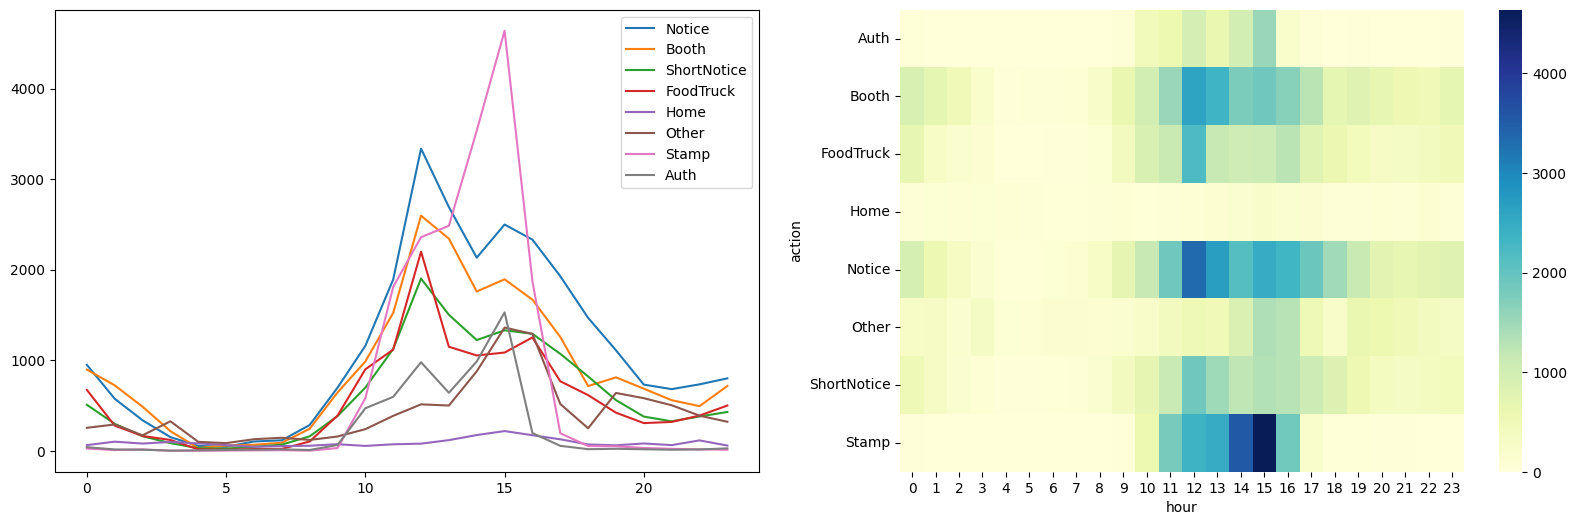

In [13]:
plt.figure(figsize=(20, 6))

for i in df["action"].unique():
    plt.subplot(1,2,1,)
    subset = df[df["action"] == i]
    counts = subset["hour"].value_counts().sort_index()
    plt.plot(counts.index, counts.values, label=i)
    plt.legend()

plt.subplot(1,2,2)
sns.heatmap(
    df.pivot_table(index="action", columns="hour", aggfunc="size", fill_value=0),
    cmap="YlGnBu",
    fmt="d"
)
plt.show()

- 행동 로그 분석 결과, 사용자 활동은 오전 10시 이후 급격히 증가했으며,
- 특히 14–15시 사이 스탬프 기능 사용이 정점을 찍었다.
- 이는 해당 기능이 단순한 부가 요소가 아니라,
- 현장 참여를 유도하는 핵심 동기 장치로 작동했음을 시사한다.

- 또한 공지사항에는 티켓 유형별 입장 대기 및 입장 시각이 안내되어 있었으며,
공지 열람 행동은 실제 티켓 입장 시간대(12:30–16:30)에 맞춰 유의미하게 증가하는 패턴을 보였다.
특히 입장 시작 직전 시간대에 공지 열람이 집중된 점으로 미루어,
사용자들은 현장 도착 전 또는 대기 중에 입장 정보를 재확인하기 위해 공지사항을 적극적으로 활용한 것으로 해석된다.


🌊입장 시간 안내
❗티켓별 대기 및 입장 시간
✔A티켓 : 12:25 - 12:55 / 13:00 - 13:30
✔B티켓 : 13:00 - 13:30 / 13:35 - 14:05
✔C티켓 : 13:35 - 14:05 / 14:10 - 14:40
✔D티켓 : 14:10 - 14:40 / 14:45 - 15:15
✔E티켓 : 14:45 - 15:15 / 15:20 - 15:50
✔F티켓 : 15:20 - 15:50 / 15:55 - 16:25
✔G티켓 : 15:55 - 16:25 / 16:30 - 입장 마감까지
*좌측 대기 시간에 대기 후, 우측 입장 시간에 입장 시작할 예정입니다.
*대기 시간에 오셔서, 바닥에 붙여진 본인 번호에 맞게 대기 부탁드립니다.

# 스탬프 이전 행동 분석

- /api/booth/undefined
- /api/auth/login 404
피크 시간대와 겹치는 에러

In [14]:
df

,ts,ip,method,uri,status,time,ua,action,hour
0,2025-05-20 04:46:36+00:00,110.35.168.207,GET,/api/notices/784,200,10,Mozilla/5.0 (iPhone; CPU iPhone OS 16_6 like M...,Notice,13
1,2025-05-20 04:47:14+00:00,59.187.210.89,GET,/api/booth/undefined/35,400,3,Mozilla/5.0 (iPhone; CPU iPhone OS 18_4_1 like...,Booth,13
2,2025-05-20 04:47:19+00:00,106.101.195.135,GET,/api/notices,200,1,Mozilla/5.0 (iPhone; CPU iPhone OS 18_4_1 like...,Notice,13
3,2025-05-20 04:47:28+00:00,106.101.195.135,GET,/api/booth/20,200,7,Mozilla/5.0 (iPhone; CPU iPhone OS 18_4_1 like...,Booth,13
4,2025-05-20 04:47:30+00:00,211.234.204.113,GET,/api/short-notices,200,1,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,ShortNotice,13
...,...,...,...,...,...,...,...,...,...
112718,2025-05-23 02:19:21+00:00,118.235.74.253,GET,/api/booth/23,200,4,Mozilla/5.0 (iPhone; CPU iPhone OS 18_4_1 like...,Booth,11
112719,2025-05-23 02:19:26+00:00,118.235.74.253,GET,/api/booth/23/17,200,5,Mozilla/5.0 (iPhone; CPU iPhone OS 18_4_1 like...,Booth,11
112720,2025-05-23 02:19:30+00:00,172.224.252.31,GET,/api/notices,200,1,Mozilla/5.0 (iPhone; CPU iPhone OS 18_1_1 like...,Notice,11
112721,2025-05-23 02:23:50+00:00,211.234.195.152,GET,/api/booth/23/9,200,5,Mozilla/5.0 (iPhone; CPU iPhone OS 18_4 like M...,Booth,11


In [15]:
df = df.sort_values("ts")

df["user_key"] = df["ip"].astype(str) + " | " + df["ua"].astype(str)

In [16]:
df["gap_min"] = (
    df.groupby("user_key")["ts"]
      .diff()
      .dt.total_seconds()
      .div(60)
)

df["new_session"] = df["gap_min"].isna() | (df["gap_min"] > 30)
df["session_id"] = df.groupby("user_key")["new_session"].cumsum()

df["session_key"] = df["user_key"] + " | s=" + df["session_id"].astype(str)
df.head()

,ts,ip,method,uri,status,time,ua,action,hour,user_key,gap_min,new_session,session_id,session_key
56938,2025-05-19 01:28:42+00:00,118.235.65.223,GET,/api/food-truck/19,200,6,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,FoodTruck,10,118.235.65.223 | Mozilla/5.0 (Linux; Android 1...,NaN,True,1,118.235.65.223 | Mozilla/5.0 (Linux; Android 1...
56939,2025-05-19 01:28:43+00:00,118.235.65.223,GET,/api/food-truck/19/10,200,6,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,FoodTruck,10,118.235.65.223 | Mozilla/5.0 (Linux; Android 1...,0.016667,False,1,118.235.65.223 | Mozilla/5.0 (Linux; Android 1...
70003,2025-05-19 01:28:44+00:00,39.7.231.147,GET,/api/food-truck/19/10,200,6,Mozilla/5.0 (iPhone; CPU iPhone OS 18_4_1 like...,FoodTruck,10,39.7.231.147 | Mozilla/5.0 (iPhone; CPU iPhone...,NaN,True,1,39.7.231.147 | Mozilla/5.0 (iPhone; CPU iPhone...
48869,2025-05-19 01:28:49+00:00,118.235.65.223,GET,/api/food-truck/19/10,200,6,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,FoodTruck,10,118.235.65.223 | Mozilla/5.0 (Linux; Android 1...,0.100000,False,1,118.235.65.223 | Mozilla/5.0 (Linux; Android 1...
61437,2025-05-19 01:28:57+00:00,59.187.210.211,GET,/api/food-truck/19,200,6,Mozilla/5.0 (iPhone; CPU iPhone OS 18_4_1 like...,FoodTruck,10,59.187.210.211 | Mozilla/5.0 (iPhone; CPU iPho...,NaN,True,1,59.187.210.211 | Mozilla/5.0 (iPhone; CPU iPho...


In [17]:
df["session_key"].nunique()

17190

In [18]:
stamp_sessions = df[df["action"] == "Stamp"]["session_key"].unique()
df_stamp = df[df["session_key"].isin(stamp_sessions)].copy()
df_stamp.head()

,ts,ip,method,uri,status,time,ua,action,hour,user_key,gap_min,new_session,session_id,session_key
61444,2025-05-19 01:32:00+00:00,211.234.192.231,POST,/api/auth/login,404,8,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like...,Auth,10,211.234.192.231 | Mozilla/5.0 (iPhone; CPU iPh...,NaN,True,1,211.234.192.231 | Mozilla/5.0 (iPhone; CPU iPh...
70013,2025-05-19 01:32:05+00:00,211.234.192.231,POST,/api/auth/login,404,7,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like...,Auth,10,211.234.192.231 | Mozilla/5.0 (iPhone; CPU iPh...,0.083333,False,1,211.234.192.231 | Mozilla/5.0 (iPhone; CPU iPh...
70015,2025-05-19 01:32:18+00:00,211.234.192.231,GET,/api/short-notices,200,8,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like...,ShortNotice,10,211.234.192.231 | Mozilla/5.0 (iPhone; CPU iPh...,0.216667,False,1,211.234.192.231 | Mozilla/5.0 (iPhone; CPU iPh...
70014,2025-05-19 01:32:18+00:00,211.234.192.231,GET,/api/notices,200,5,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like...,Notice,10,211.234.192.231 | Mozilla/5.0 (iPhone; CPU iPh...,0.000000,False,1,211.234.192.231 | Mozilla/5.0 (iPhone; CPU iPh...
48879,2025-05-19 01:32:23+00:00,211.234.192.231,GET,/api/notices,200,3,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like...,Notice,10,211.234.192.231 | Mozilla/5.0 (iPhone; CPU iPh...,0.083333,False,1,211.234.192.231 | Mozilla/5.0 (iPhone; CPU iPh...


In [19]:
df_stamp = df_stamp.sort_values(["session_key", "ts"])

# Stamp 바로 이전 행동 찾기
prev_actions = []

for sk, g in df_stamp.groupby("session_key"):
    acts = g["action"].tolist()
    for i in range(1, len(acts)):
        if acts[i] == "Stamp":
            prev_actions.append(acts[i-1])

pd.Series(prev_actions).value_counts()

Stamp          12680
Other           1687
Auth            1096
Notice            85
ShortNotice       67
Booth             49
FoodTruck         17
Name: count, dtype: int64

In [20]:
prev_actions = []

for sk, g in df_stamp.groupby("session_key"):
    acts = g.sort_values("ts")["action"].tolist()

    for i in range(len(acts)):
        if acts[i] == "Stamp":
            # 첫 Stamp만 잡는다
            if i > 0 and acts[i-1] != "Stamp":
                prev_actions.append(acts[i-1])
            break  # Stamp 블록 진입 후는 관심 없음

pd.Series(prev_actions).value_counts()

Auth           761
Other          714
ShortNotice     34
Notice          25
Booth           15
FoodTruck        3
Name: count, dtype: int64

- 스탬프는 기능 상 무조건 적 로그인

In [21]:
stamp_sessions = set(
    df[df["action"] == "Stamp"]["session_key"]
)

df["stamp_user"] = df["session_key"].apply(
    lambda x: 1 if x in stamp_sessions else 0
)
df["stamp_user"].value_counts()

stamp_user
0    80304
1    32419
Name: count, dtype: int64

In [22]:
def create_session_summary(df):
    """
    세션별 요약 통계(session_summary) 데이터프레임을 생성합니다.
    PDF의 [88]번 입력 셀 이전에 실행되어야 하는 코드입니다.
    """
    
    # 1. 집계 함수 정의
    aggregations = {
        'stamp_user': 'max',              # 세션이 스탬프 유저인지 (1 또는 0)
        'action': ['count', 'nunique'],   # 총 행동 횟수, 고유 행동 종류 수
        'ts': lambda x: (x.max() - x.min()).total_seconds()  # 세션 체류 시간 (초)
    }
    
    # 2. 기본 집계 수행 (세션 키 기준)
    session_summary = df.groupby('session_key').agg(aggregations)
    
    # 3. 컬럼 이름 평탄화 (MultiIndex 정리)
    session_summary.columns = [
        'stamp_user', 
        'action_count', 
        'unique_actions', 
        'session_time'
    ]
    
    # 4. 특정 행동(Action)별 카운트 추가 (Booth, Notice, Auth)
    # PDF [702-711] 결과에 맞추기 위해 특정 행동의 횟수를 계산합니다.
    
    # Booth 뷰 카운트
    session_summary['booth_views'] = df[df['action'] == 'Booth'].groupby('session_key').size()
    
    # Notice 뷰 카운트
    session_summary['notice_views'] = df[df['action'] == 'Notice'].groupby('session_key').size()
    
    # Auth 시도 카운트
    session_summary['auth_count'] = df[df['action'] == 'Auth'].groupby('session_key').size()
    
    # 5. NaN 값(행동이 0번인 경우)을 0으로 채우기
    session_summary = session_summary.fillna(0)
    
    # 6. 정수형 변환이 필요한 컬럼 처리
    cols_to_int = ['stamp_user', 'action_count', 'unique_actions', 'booth_views', 'notice_views', 'auth_count']
    session_summary[cols_to_int] = session_summary[cols_to_int].astype(int)
    
    return session_summary

# --- 사용 예시 ---
# df는 앞서 만든 load_and_process_logs()로 불러온 데이터프레임입니다.
# session_summary = create_session_summary(df)
# print(session_summary.head())

In [24]:
session_summary = create_session_summary(df)
session_summary.groupby("stamp_user")[
    [
        "action_count",
        "unique_actions",
        "booth_views",
        "notice_views",
        "auth_count",
        "session_time"
    ]
].mean()

,action_count,unique_actions,booth_views,notice_views,auth_count,session_time
stamp_user,,,,,,
0,5.916888,2.045830,1.413056,1.793177,0.068008,92.362511
1,8.960475,2.380321,0.631841,0.682698,1.325871,359.900774


- 스탬프 페이지를 이용한 사용자 그룹에서 평균 세션 시간이 더 길게 관찰되었다

- 스탬프 페이지를 이용한 사용자는 그렇지 않은 사용자에 비해 평균적으로 더 긴 세션 시간을 보였으나, 이는 스탬프 기능 자체의 효과라기보다는 이미 참여도가 높은 사용자가 해당 기능을 선택했을 가능성을 배제할 수 없다.

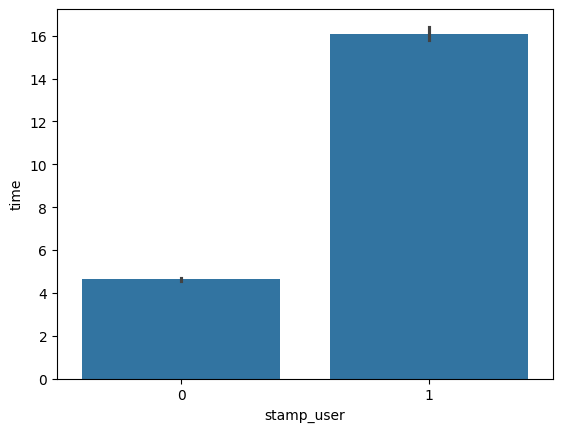

In [25]:
sns.barplot(x=df["stamp_user"], y=df["time"])
plt.show()

# 스탬프 기능 사용자의 채류 시간 : 로그인 때문?

In [26]:
df = df.sort_values(["session_key", "ts"])

df["delta_sec"] = (
    df.groupby("session_key")["ts"]
      .diff()
      .dt.total_seconds()
)

In [27]:
action_time = (
    df.groupby(["stamp_user", "action"])["delta_sec"]
      .mean()
      .reset_index()
)
action_time

,stamp_user,action,delta_sec
0,0,Auth,8.140625
1,0,Booth,17.680505
2,0,FoodTruck,18.505132
3,0,Home,165.585492
4,0,Notice,18.330438
5,0,Other,14.573047
6,0,ShortNotice,19.668171
7,1,Auth,23.688183
8,1,Booth,24.991510
9,1,FoodTruck,20.403337


In [28]:
df["long_wait"] = df["delta_sec"] > 120

In [29]:
session_wait = (
    df.groupby(["session_key", "stamp_user"])["long_wait"]
      .mean()
      .reset_index(name="long_wait_ratio")
)

In [30]:
session_wait.groupby("stamp_user")["long_wait_ratio"].mean()

stamp_user
0    0.014907
1    0.040033
Name: long_wait_ratio, dtype: float64

스탬프 사용자는 비스탬프 사용자 대비 액션 간 장시간 대기 구간을 더 자주 경험했다.
- 약 2.7배 차이
- 그러나 온라인 행동 로그 사이에 오프라인 행동이 개입된 체류일 가능성이 있다.
- 더불어 스탬프 수집 과정 내의 필연적 대기 구간을 포함한다.

In [31]:
repeat_rate = (
    df.groupby("session_key")["action"]
      .apply(lambda x: x.value_counts().iloc[0] / len(x))
      .reset_index(name="repeat_ratio")
)

In [32]:
repeat_rate["stamp_user"] = repeat_rate["session_key"].isin(
    df[df["action"] == "Stamp"]["session_key"]
)

repeat_rate.groupby("stamp_user")["repeat_ratio"].mean()

stamp_user
False    0.708562
True     0.748758
Name: repeat_ratio, dtype: float64

Stamp 유저의 체류는 다양한 콘텐츠 탐색으로 확장되기보다는
동일 기능 내 반복 행동으로 구성된 경향이 있다.
- 사용자의 반복적 스탬프 부스 사용을 확인 할 수 있어 적극적인 사용자로 구분 가능하다.

- 스탬프 적립 과정은 사용자 단독 행동이 아닌, 부스 운영자의 비밀번호 입력이 필요한 구조로 설계되어 있다.
- 이에 따라 스탬프 사용자 세션에서는 운영자 응답을 기다리는 대기 구간과 적립 여부를 확인하는 반복 행동이 자연스럽게 발생한다.


**이는 서비스 오류라기보다는,오프라인 운영 개입이 포함된 이벤트형 서비스의 구조적 특성으로 해석할 수 있다**

# 스탬프 기능 이용자 사용 경로

In [33]:
df = df.sort_values(["user_key", "ts"])

In [34]:
user_sequences = (
    df.groupby("user_key")["action"]
      .apply(list)
      .reset_index(name="sequence")
)

In [35]:
user_sequences["is_stamp_user"] = user_sequences["sequence"].apply(
    lambda x: 1 if "Stamp" in x else 0
)
user_sequences.head()

,user_key,sequence,is_stamp_user
0,1.1.1.1 | Mozilla/5.0 (Windows NT 10.0; Win64;...,"[Home, Home]",0
1,1.1.1.1 | Mozilla/5.0 (Windows NT 10.0; Win64;...,[Home],0
2,1.1.1.1 | Mozilla/5.0 (Windows NT 10.0; Win64;...,[Home],0
3,1.1.1.1 | Mozilla/5.0 (Windows NT 10.0; Win64;...,[Home],0
4,1.1.1.1 | Mozilla/5.0 (Windows NT 10.0; Win64;...,[Home],0


In [36]:
from collections import Counter

def extract_paths(seq, n=3):
    return [tuple(seq[i:i+n]) for i in range(len(seq)-n+1)]

paths = []
for seq in user_sequences["sequence"]:
    paths.extend(extract_paths(seq, 3))

path_counts = Counter(paths)
top_paths = path_counts.most_common(10)

top_paths


[(('Booth', 'Booth', 'Booth'), 12177),
 (('Stamp', 'Stamp', 'Stamp'), 9994),
 (('FoodTruck', 'FoodTruck', 'FoodTruck'), 8355),
 (('Notice', 'ShortNotice', 'Notice'), 4745),
 (('Other', 'Other', 'Other'), 4711),
 (('Notice', 'Notice', 'Notice'), 4373),
 (('ShortNotice', 'Notice', 'Notice'), 3646),
 (('Notice', 'Notice', 'ShortNotice'), 3273),
 (('Auth', 'Auth', 'Auth'), 2116),
 (('ShortNotice', 'Notice', 'ShortNotice'), 1806)]

In [37]:
def first_action(seq):
    return seq[0]

def last_action(seq):
    return seq[-1]

user_sequences["entry"] = user_sequences["sequence"].apply(first_action)
user_sequences["exit"] = user_sequences["sequence"].apply(last_action)

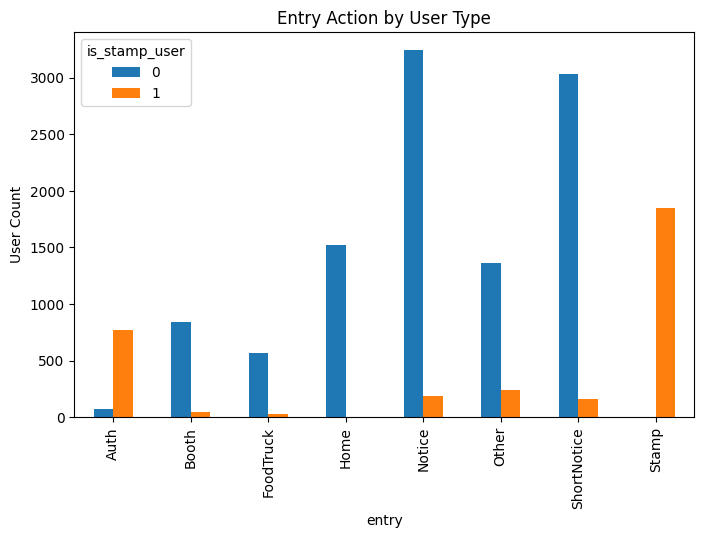

In [38]:
entry_dist = (
    user_sequences
    .groupby(["is_stamp_user", "entry"])
    .size()
    .unstack(fill_value=0)
)

entry_dist.T.plot(kind="bar", figsize=(8,5))
plt.title("Entry Action by User Type")
plt.ylabel("User Count")
plt.show()


- 스탬프 사용자는 이미 목적(스탬프 부스 참여)를 가지고 진입한 사용자이다.
- 사이트를 둘러보다 참여한 것이 아니라, 참여를 위해 들어온 사용자이다.

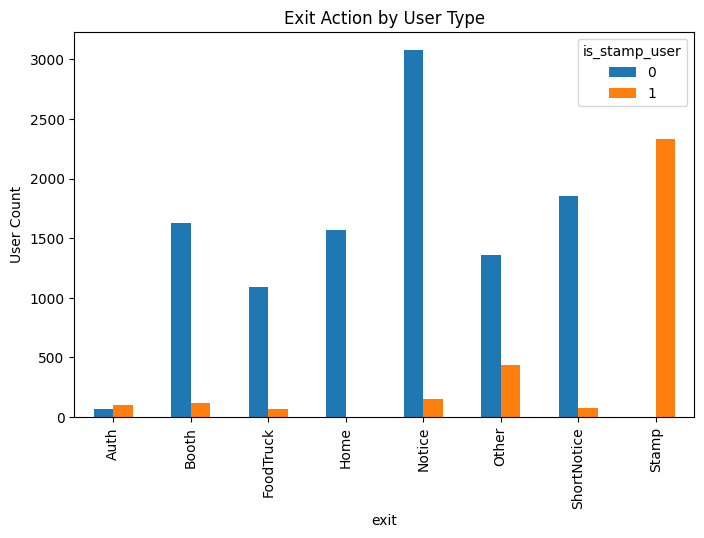

In [39]:
exit_dist = (
    user_sequences
    .groupby(["is_stamp_user", "exit"])
    .size()
    .unstack(fill_value=0)
)

exit_dist.T.plot(kind="bar", figsize=(8,5))
plt.title("Exit Action by User Type")
plt.ylabel("User Count")
plt.show()

- 스탬프 기능은 단순한 기능이 아니라 세션의 종료 지점으로 작동한다.
- 즉, 스탬프는 “중간 행동”이 아니라 행동의 종착점이다.

- 스탬프 참여 사용자는 공지 탐색을 통해 자연스럽게 전환된 것이 아니라,
- 인증(Auth)을 기점으로 스탬프 기능을 목표로 한 목적 지향적 세션 구조를 보였다.
- 스탬프 페이지는 참여 이후의 탐색으로 이어지기보다는 세션 종료 지점으로 기능하고 있었

분석 결과, 스탬프 기능은 참여를 유도하는 장치로는 효과적이었으나,
참여 이후 다른 서비스 영역으로의 확장을 유도하지는 못했다.
이는 사용자의 흥미 부족보다는, 스탬프 완료 이후의 행동 선택지가
명확히 설계되지 않았기 때문으로 해석할 수 있다.
향후에는 스탬프 완료 지점을 세션 종료가 아닌
현장 콘텐츠 탐색으로 이어지는 전환 노드로 재설계함으로써
서비스 이용 범위를 자연스럽게 확장할 수 있을 것이다.

---

In [40]:
import plotly.express as px
import plotly.graph_objects as go

In [41]:
kpi = {
    "Avg Session Time (Stamp)": session_summary[session_summary["stamp_user"]==1]["session_time"].mean(),
    "Avg Session Time (Non-Stamp)": session_summary[session_summary["stamp_user"]==0]["session_time"].mean(),
    "Long Wait Ratio (Stamp)": session_wait[session_wait["stamp_user"]==1]["long_wait_ratio"].mean()
}
kpi

{'Avg Session Time (Stamp)': np.float64(359.9007739082366),
 'Avg Session Time (Non-Stamp)': np.float64(92.36251105216623),
 'Long Wait Ratio (Stamp)': np.float64(0.04003329911844828)}

In [42]:
action_time_plot = (
    df.groupby(["stamp_user", "action"])["delta_sec"]
      .mean()
      .reset_index()
)

fig = px.bar(
    action_time_plot,
    x="action",
    y="delta_sec",
    color="stamp_user",
    barmode="group",
    labels={
        "delta_sec": "Avg Time Between Actions (sec)",
        "stamp_user": "Stamp User"
    },
    title="Action-level Dwell Time by User Type"
)

fig.show()

In [43]:
fig = px.bar(
    session_wait.groupby("stamp_user")["long_wait_ratio"].mean().reset_index(),
    x="stamp_user",
    y="long_wait_ratio",
    title="Long Wait Ratio (>120s)"
)
fig.show()
